In [17]:
import time
import os
import math
import cv2
import numpy as np
import pandas as pd
import pyautogui as pa
import shutil
import imageio
from PIL import Image, ImageDraw
import random
from scipy.stats import norm, kstest, sem, ttest_ind, linregress

from lib.analysis.trace_metrics import TraceMetrics
from lib.analysis.false_discovery_control import false_discovery_control
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.TIF import *
from lib.analysis.align import ImageAlign
from lib.utilities import *
from lib.file.ROI_writer import ROIFileWriter
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.barrel_roi import Barrel_ROI_Creator

# This script uses the export summary created by the OrchestraZ auto export application feature
#  to analyze the data


In [18]:
# load trace files from the following directory
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/theta-Calcrl/"
export_summary = data_dir + "export_summary_calcrl.csv"
catalog_file = data_dir + "theta_catalog.csv"

camera_program = 4
um_per_px = 6.0 #um

In [19]:
def read_traces_file(filename): 
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)
    return data_arr

# open export summary csv
df = pd.read_csv(export_summary)

# open catalog file
catalog_df = pd.read_csv(catalog_file)

# normalize latency
actual_stim_time = 48.9
df['latency'] = df['latency'] - actual_stim_time
df

,ROI,amp,snr,latency,halfwidth,Stim_Distance,ROI_Set,Date,Slice,Location,Recording,trace,snr_array
0,1,2.91594,17.83850,0.5779,4.97997,12.000000,1_2_1roi,7/26/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
1,2,4.06318,12.45270,0.3830,3.77557,26.832816,1_2_1roi,7/26/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
2,3,3.71713,15.95200,0.5110,4.27915,48.000000,1_2_1roi,7/26/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
3,4,3.24216,11.14300,0.8073,4.43570,8.485281,1_2_1roi,7/26/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
4,5,3.90170,10.23460,0.1509,4.31240,32.310989,1_2_1roi,7/26/2024,1,2,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,8,1.80617,3.66604,0.0843,23.44610,26.832816,1_1_1roi,8/6/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
287,9,1.51687,3.29921,13.5404,8.72893,78.230429,1_1_1roi,8/6/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
288,10,1.32503,2.28134,5.3425,14.39980,133.221620,1_1_1roi,8/6/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
289,11,2.07591,3.82142,9.0244,13.88480,112.729765,1_1_1roi,8/6/2024,1,1,1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...


7/26/2024 1 2 1 1


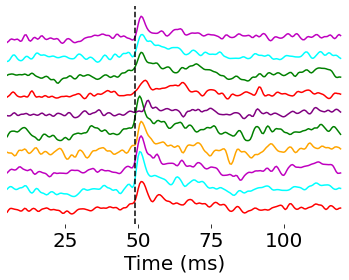

7/26/2024 1 2 1 2


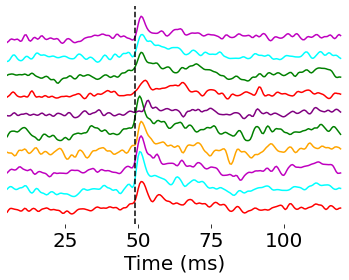

7/26/2024 1 2 1 3


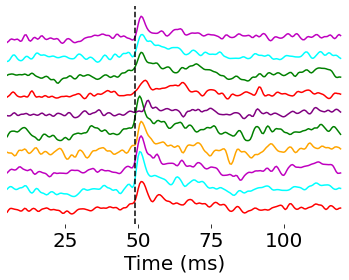

7/26/2024 1 2 1 4


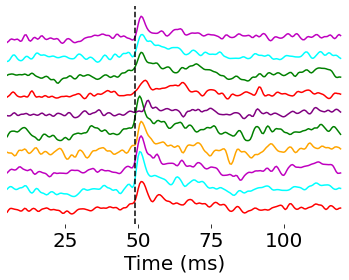

7/26/2024 1 2 1 5


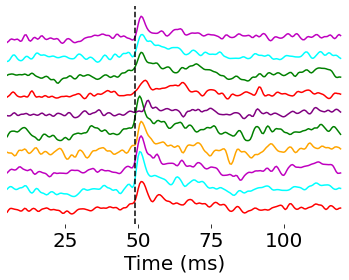

7/26/2024 1 2 1 6


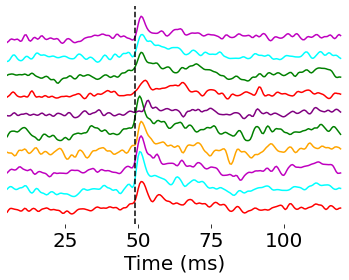

7/26/2024 1 2 1 7


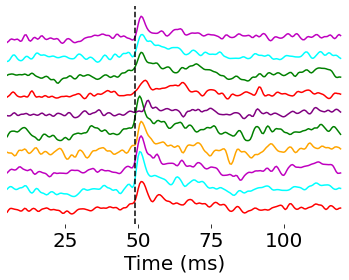

7/26/2024 1 2 1 8


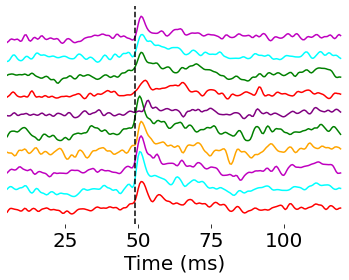

7/26/2024 1 2 1 9


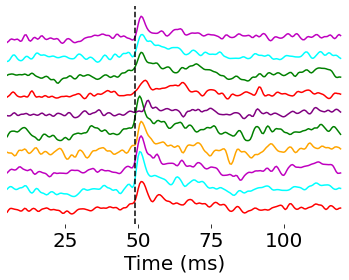

7/26/2024 1 2 1 10


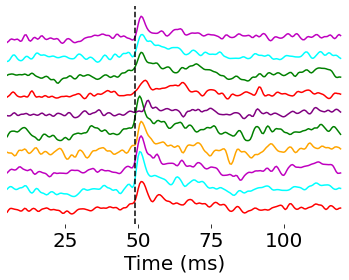

7/26/2024 1 2 2 1


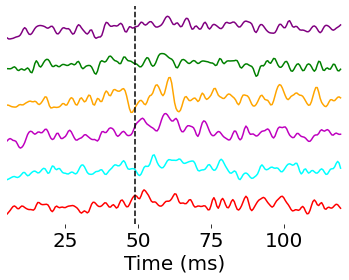

7/26/2024 1 2 2 2


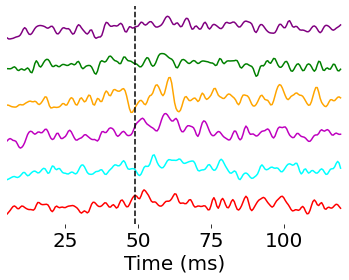

7/26/2024 1 2 2 3


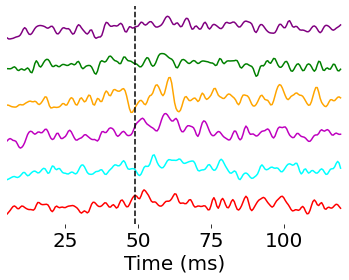

7/26/2024 1 2 2 4


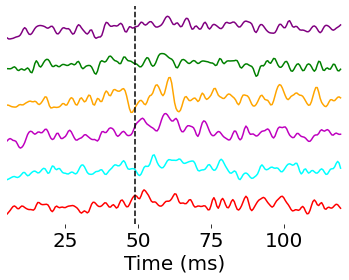

7/26/2024 1 2 2 5


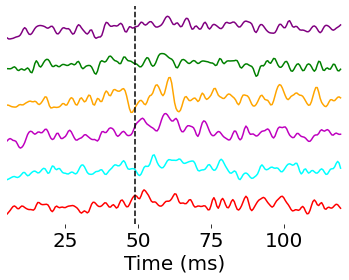

7/26/2024 1 2 2 6


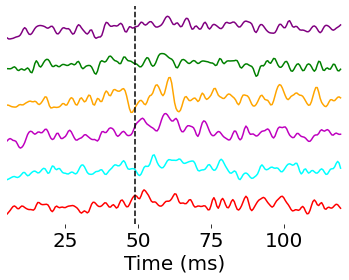

7/26/2024 1 2 3 1


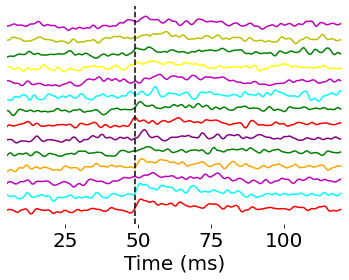

7/26/2024 1 2 3 2


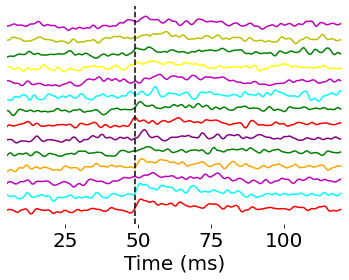

7/26/2024 1 2 3 3


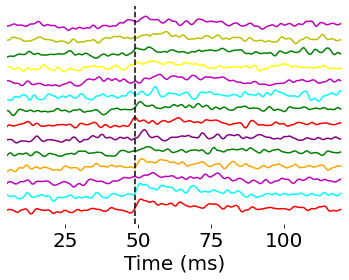

7/26/2024 1 2 3 4


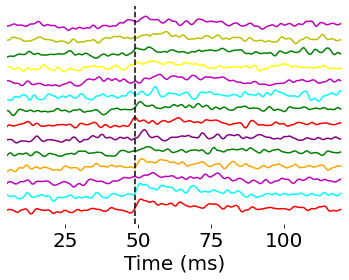

In [20]:
# plot traces
n_plots = 20
for date in df['Date'].unique():
    df_date = df[df['Date'] == date]
    for slic_id in df_date['Slice'].unique():
        df_slic = df_date[df_date['Slice'] == slic_id]
        for loc_id in df_slic['Location'].unique():
            df_loc = df_slic[df_slic['Location'] == loc_id]
            for rec_id in df_loc['Recording'].unique():
                df_rec = df_loc[df_loc['Recording'] == rec_id]
                for roi_id in df_rec['ROI'].unique():
                    df_roi = df_rec[df_rec['ROI'] == roi_id]

                    if n_plots == 0:
                        continue

                    # trace filename
                    trace_filename = df_roi['trace'].values[0]
                    trace = read_traces_file(trace_filename)

                    tm = TraceMetrics(trace)
                    print(date, slic_id, loc_id, rec_id, roi_id)
                    tm.show_traces(measure_window=[10, 240], 
                            legend=False, 
                            colors=['r', 'cyan', 'm', 'orange', 'green', 'purple',
                                    'r', 'green', 'cyan', 'm', 'yellow', 'g', 'y', 'm', 'c', 'k'],
                            stim_time=actual_stim_time,
                            headroom=2,
                                    )
                    n_plots -= 1
                    
                    """tm.frequency_decomposition(measure_window=[94, 140],
                                                xlim=[20, 400])"""

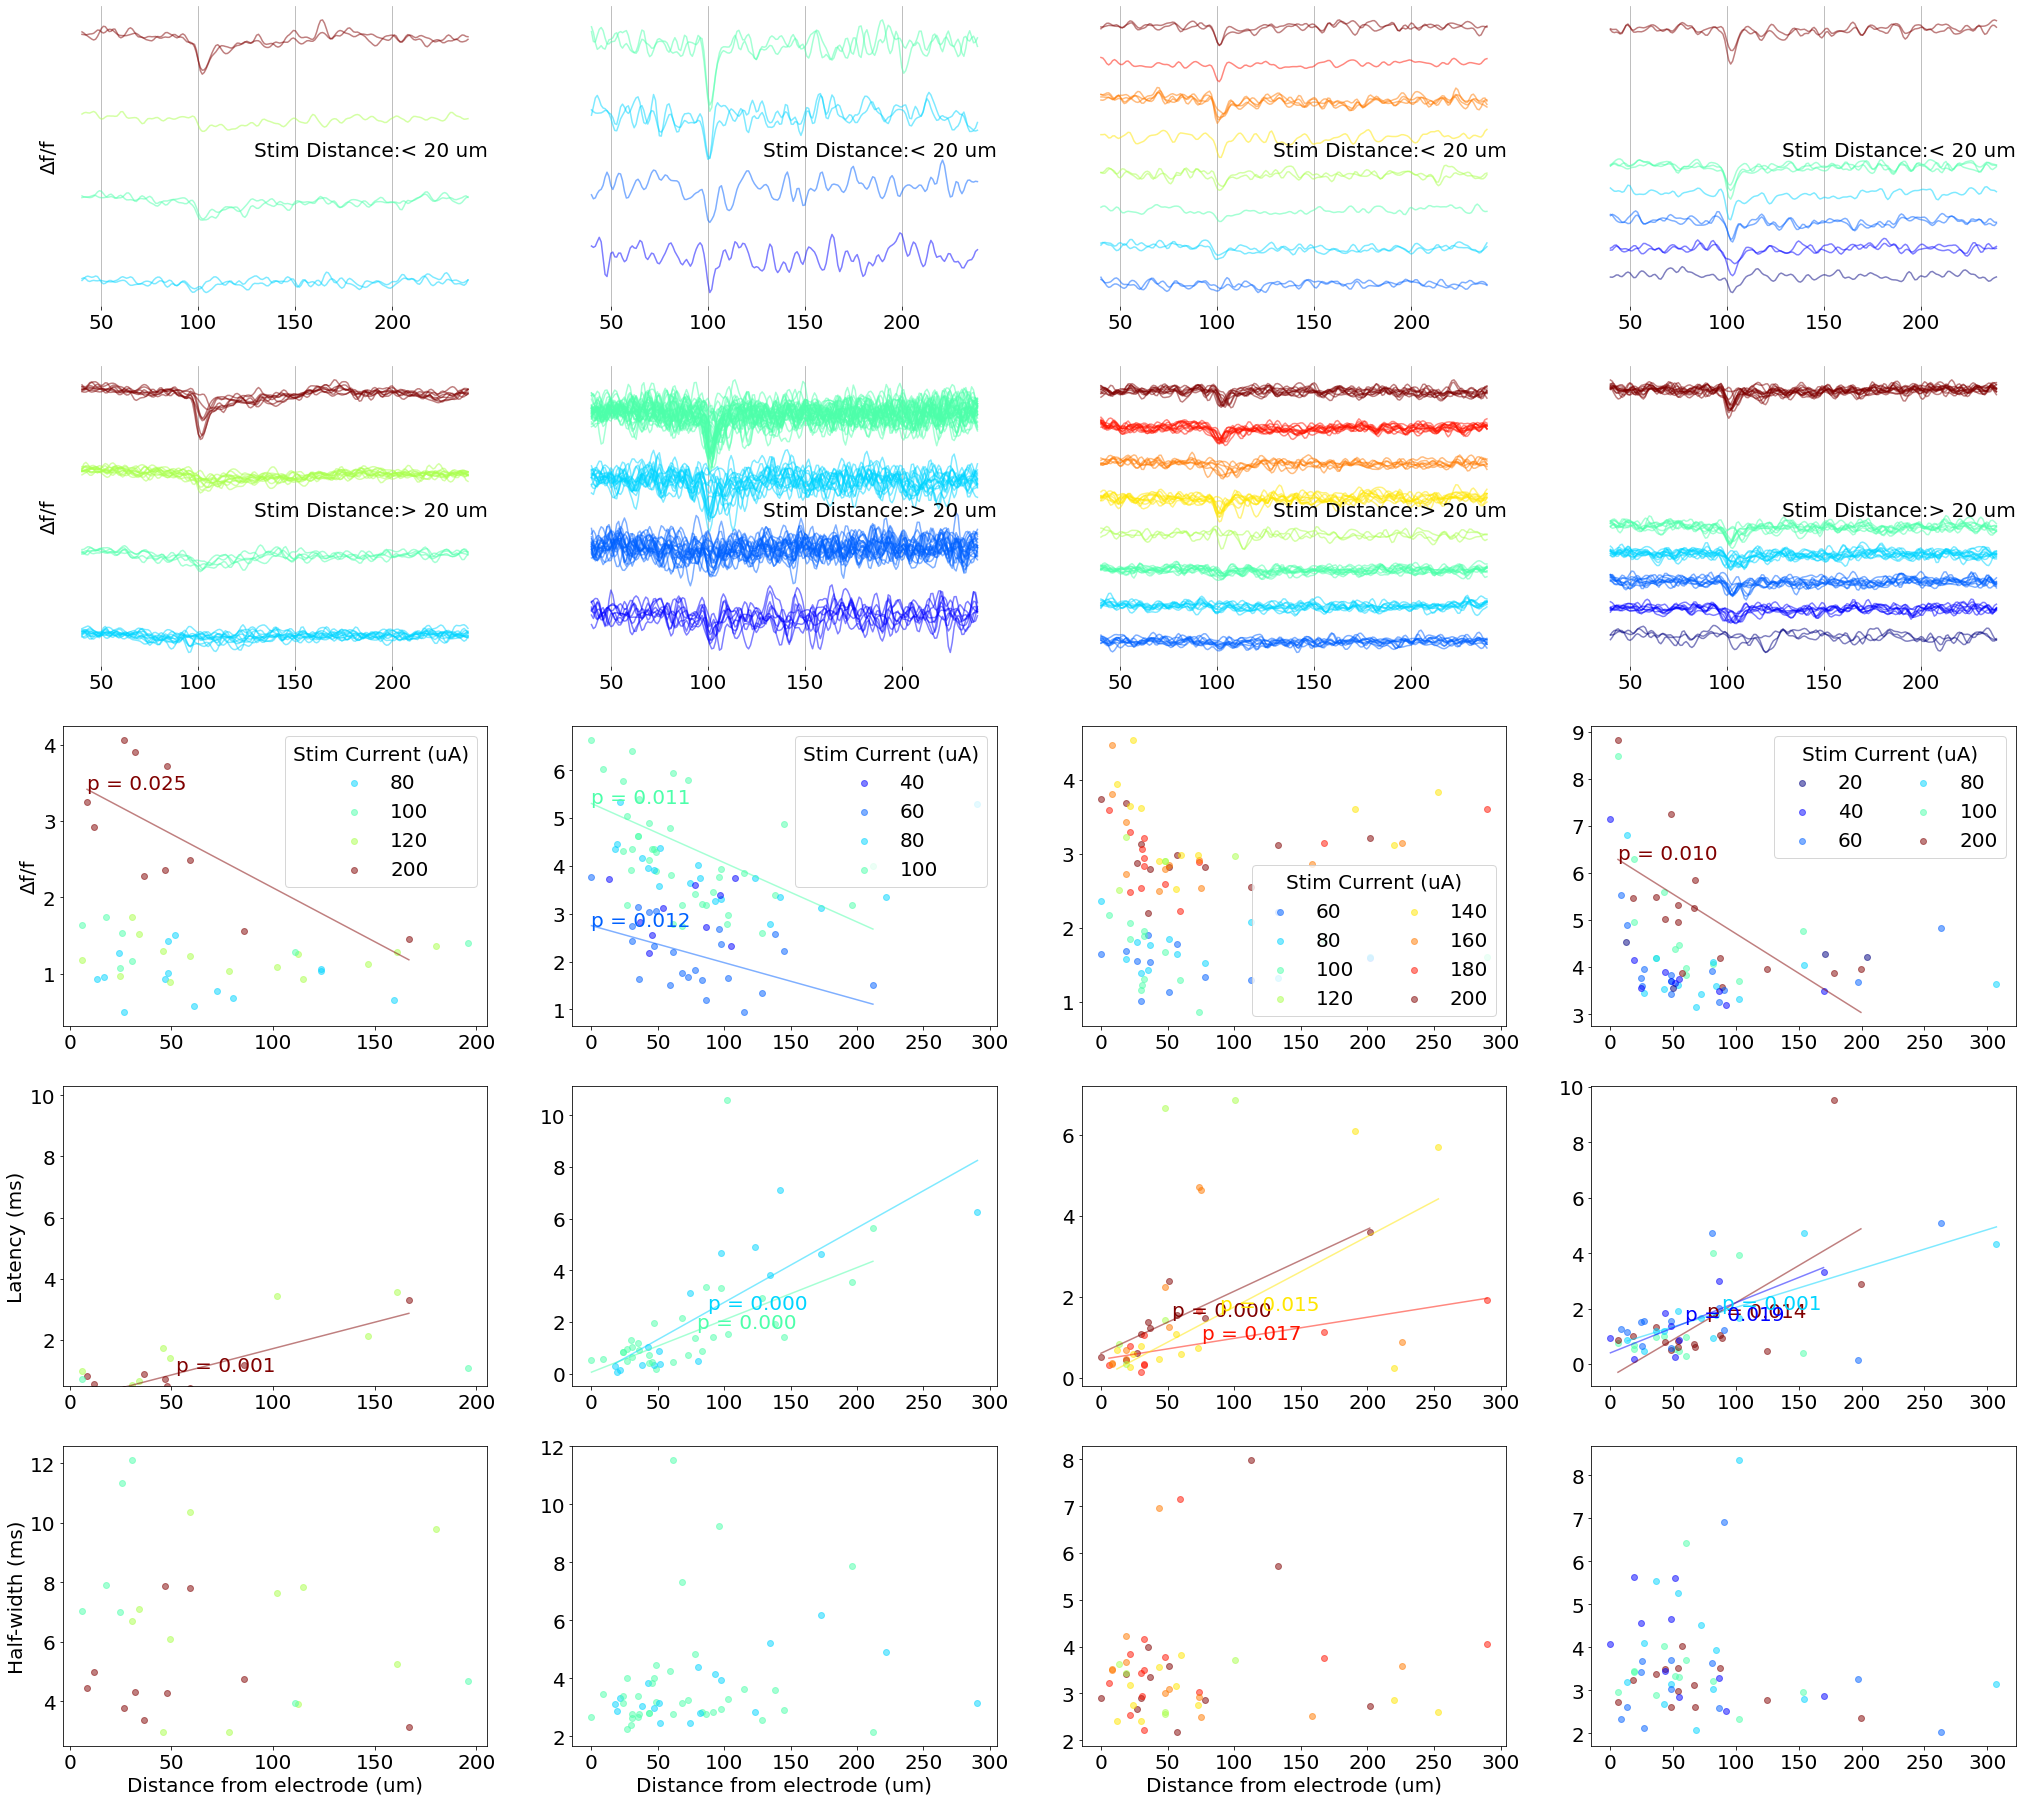

In [23]:
# set matplotlib font size to 16
plt.rcParams.update({'font.size': 20})
fig, ax = plt.subplots(5, 4, figsize=(35, 32))

roi_type = 'non_soma'

# color list from cold to hot
stim_color_map = {}
min_stim = min(catalog_df['Stim_Current'])
max_stim = max(catalog_df['Stim_Current'])
for stim_current in catalog_df['Stim_Current'].unique():
    # min-max nomralize the stim current to a value between 0 and 1
    stim_color_map[stim_current] = plt.cm.jet((stim_current - min_stim) / (max_stim - min_stim))

stim_legend = {}
stim_order = list(stim_color_map.keys())
stim_order.sort()

is_annotated = {}
handles = {}
for ix in range(3):
    ax[4, ix].set_xlabel("Distance from electrode (um)")
ax[3, 0].set_ylim(1.5, 3.3)
headroom = 6.8
for date in df['Date'].unique():
    if "PP" in date:
        continue
    df_date = df[df['Date'] == date]
    if date is not None:
        date = parse_date(date, long_year=True).replace("-", "/")

    # sort by date
    i_date = {'7/26/2024': 0,
                '8/1/2024': 1,
                '8/6/2024': 2,}[date]
    
    for slic_id in df_date['Slice'].unique():
        df_slic = df_date[df_date['Slice'] == slic_id]
        for loc_id in df_slic['Location'].unique():
            df_loc = df_slic[df_slic['Location'] == loc_id]
            for i, rec_id in enumerate(df_loc['Recording'].unique()):
                df_rec = df_loc[df_loc['Recording'] == rec_id]
                
                # use catalog to tell what stim current was used
                catalog_df_subset = catalog_df[(catalog_df['Date'] == date) &
                                                (catalog_df['Slice'] == slic_id) &
                                                (catalog_df['Loc'] == loc_id) & 
                                                (catalog_df['Recording'] ==  rec_id)]
                stim_current = catalog_df_subset['Stim_Current'].values[0]
                electrode_type = catalog_df_subset['Electrode_Type'].values[0]

                trace_filename = df_rec['trace'].values[0]  # all rois for this recording are in the same trace file
                sample_traces = read_traces_file(trace_filename)
    
                if electrode_type == 'single':
                    color = stim_color_map[stim_current]

                    for j, col_name in enumerate(sample_traces.columns):
                        if col_name == 'Pt':
                            continue

                        measure_window = [40, 240]

                        x = sample_traces['Pt'][measure_window[0]:measure_window[1]]
                        
                        # get stim distance
                        stim_dist = df_rec[df_rec['ROI'] == j]['Stim_Distance'].values[0]

                        '''min_dist = min(df_loc['Stim_Distance'])
                        max_dist = max(df_loc['Stim_Distance'])

                        # divide the stim distances into 3 bins
                        dist_bin_size = (max_dist - min_dist) / 3
                        lower_bin_border = min_dist + dist_bin_size
                        upper_bin_border = lower_bin_border + dist_bin_size'''

                        stim_dist_border = 20

                        # get the bin for this stim distance
                        i_bin = 0 if stim_dist < stim_dist_border else 1
                            
                        i_div = i_date

                        if i_div == 2:
                            # differentiate between the two locations
                            i_div += (loc_id - 1)

                        annotate = "Stim Distance:"
                        if i_bin == 0:
                            annotate += "< " + str(stim_dist_border)[:4] + " um"
                        elif i_bin == 1:
                            annotate += "> " + str(stim_dist_border)[:4] + " um"

                        if str(i_bin) + "_" + str(i_div) not in is_annotated:
                            ax[i_bin, i_div].annotate(annotate, (0.45, 0.5), xycoords='axes fraction')
                            is_annotated[str(i_bin) + "_" + str(i_div)] = True
                        
                        y_loc = headroom * stim_order.index(stim_current)
                        if i_div == 0 and stim_current == 200:
                            y_loc = headroom * stim_order.index(140)
                        ax[i_bin, i_div].plot(x, -sample_traces[col_name][measure_window[0]:measure_window[1]] + y_loc, color=color, alpha=0.5)
                        ax[i_bin, 0].set_ylabel("Δf/f")
                        ax[i_bin, i_div].set_yticks([])
                        ax[i_bin, i_div].grid(True)
                        ax[i_bin, i_div].spines['top'].set_visible(False)
                        ax[i_bin, i_div].spines['right'].set_visible(False)
                        ax[i_bin, i_div].spines['bottom'].set_visible(False)
                        ax[i_bin, i_div].spines['left'].set_visible(False)

                # plot latency vs distance, half-width vs distance, max-amp time, and amplitude vs distance
                # each amplitude has a different color
                # scatter plot in the first column
                for i_plotrow, response_type in enumerate(['amp', 'latency', 'halfwidth']):
                    i_plotrow += 2
                    subset_df4 = df_rec[(df_rec[response_type] > 0) & 
                                            (df_rec['amp'] > 0.03)]
                    j_roi = i_div

                    threshold = {0: 100, 1:80, 2: 120, 3:40}[i_div]

                    if response_type != 'amp' and stim_current < threshold:
                        continue
                    
                    # linear regression for this stim current subset
                    slope, intercept, r_value, p_value, std_err = linregress(subset_df4['Stim_Distance'], subset_df4[response_type])
                    
                
                    handle = ax[i_plotrow, j_roi].scatter(subset_df4['Stim_Distance'], subset_df4[response_type], 
                                            color=stim_color_map[stim_current], 
                                            label=str(stim_current),
                                            alpha=0.5)
                    
                    # plot the linear regression line

                    # only if p_value is less than 0.05
                    if p_value < 0.05 and len(subset_df4['Stim_Distance']) > 3:
                        x = np.linspace(min(subset_df4['Stim_Distance']), max(subset_df4['Stim_Distance']), 100)
                        y = slope * x + intercept
                        ax[i_plotrow, j_roi].plot(x, y, color=stim_color_map[stim_current], alpha=0.5)

                        # label the linear regression line with the slope and p-value

                        y_annotation = i * 1/7
                        x_annotation = .84
                        xyc = 'axes fraction'
                        if response_type == 'amp' or response_type == 'halfwidth':
                            y_annotation = slope * min(subset_df4['Stim_Distance']) + intercept
                            x_annotation = min(subset_df4['Stim_Distance']  )
                            xyc = 'data'
                        if response_type == 'latency':
                            y_annotation = slope * np.mean(subset_df4['Stim_Distance']  ) + intercept + 0.1
                            x_annotation = np.mean(subset_df4['Stim_Distance']  )
                            xyc = 'data'

                        ax[i_plotrow, j_roi].annotate(f"p = {p_value:.3f}", 
                                                (x_annotation, y_annotation),
                                                color=stim_color_map[stim_current],
                                                xycoords=xyc)
                    if i_div not in handles:
                        handles[i_div] = {}
                    handles[i_div][stim_current] = handle
                    ax[i_plotrow, 0].set_ylabel({'amp' : 'Δf/f', 
                                                'halfwidth': 'Half-width (ms)', 
                                                'latency': 'Latency (ms)', 
                                                'Max_Amp_Time': 'Time to peak (ms)'}[response_type])

handle_keys = list(stim_legend.keys())
handle_keys.sort()

for i_div in handles:
    handle_keys = list(handles[i_div].keys())
    handle_keys.sort()
    handle_div = [handles[i_div][k] for k in handle_keys]
    n_col = 1
    if len(handle_div) > 4:
        n_col = 2
    ax[2, i_div].legend(handles=handle_div, title="Stim Current (uA)", ncol=n_col)

ax[1, 0].set_ylabel("Δf/f")
ax[3, 0].set_ylim(0.5, 10.3)

plt.savefig("P:/John/crossing-paper/input/output-cal-crl-theta.png")
plt.show()


                        

## 